In [1]:
import numpy as np
import random
from pathlib import Path
import torch.nn as nn
from collections import defaultdict
import itertools
import torch
from torch.utils.data import DataLoader, TensorDataset
import sqlite3
import psycopg
from typing import Iterator, Generator
import torch.nn.functional as F
from transformers import get_scheduler
from torch import optim
from model import NsfwClassifier
import json
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt

In [2]:
def read_existing_scores() -> dict[str, str]:
	if not Path("manual_scores.json").exists():
		return {}

	with open("manual_scores.json", "r") as f:
		return json.load(f)

In [3]:
# Build dataset
ratings = list(read_existing_scores().items())

# Sort by path to keep deterministic
ratings = sorted(ratings, key=lambda rating: rating[0])
random.Random(0).shuffle(ratings)

# Break into categories
ratings_by_category = defaultdict(list)
for rating in ratings:
	ratings_by_category[rating[1]].append(rating)

for category, ratings in ratings_by_category.items():
	print(f"{category}: {len(ratings)}")

# Balance dataset
max_count = len(ratings_by_category[1])
ratings_by_category = {category: ratings[:max_count] for category, ratings in ratings_by_category.items()}

# Split
train_dataset_by_category = {category: ratings[:int(len(ratings) * 0.8)] for category, ratings in ratings_by_category.items()}
test_dataset_by_category = {category: ratings[int(len(ratings) * 0.8):] for category, ratings in ratings_by_category.items()}

# Combine
train_dataset = list(itertools.chain(*train_dataset_by_category.values()))
test_dataset = list(itertools.chain(*test_dataset_by_category.values()))

# Sort by path to keep deterministic
train_dataset = sorted(train_dataset, key=lambda rating: rating[0])
test_dataset = sorted(test_dataset, key=lambda rating: rating[0])

# Print info
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Train dataset Grid count: {len([rating for rating in train_dataset if rating[1] == 1])}")
print(f"Train dataset None count: {len([rating for rating in train_dataset if rating[1] == 0])}")
print(f"Test dataset Grid count: {len([rating for rating in test_dataset if rating[1] == 1])}")
print(f"Test dataset None count: {len([rating for rating in test_dataset if rating[1] == 0])}")

0: 1511
1: 836
Train dataset size: 1336
Test dataset size: 336
Train dataset Grid count: 668
Train dataset None count: 668
Test dataset Grid count: 168
Test dataset None count: 168


In [4]:
# Triple check
train_paths = set([rating[0] for rating in train_dataset])
test_paths = set([rating[0] for rating in test_dataset])

print(len(train_paths.intersection(test_paths)))

0


In [5]:
def convert_to_embeddings(dataset: list[tuple[str, int]]) -> Iterator[tuple[torch.Tensor, torch.Tensor]]:
	conn = psycopg.connect(dbname='postgres', user='postgres', host=str(Path.cwd().parent / "pg-socket"))
	c = conn.cursor()

	for path, label in dataset:
		path = str(Path(path).resolve().absolute())
		c.execute("SELECT embedding FROM images WHERE path = %s", (path,))
		row = c.fetchone()
		if row is None:
			print(f"Embedding not found for {path}")
			continue

		embedding = np.frombuffer(row[0], dtype=np.float16)
		assert len(embedding) == 768
		embedding = torch.tensor(embedding, dtype=torch.float32)

		yield (embedding, torch.tensor(label, dtype=torch.long))

train_dataset = list(convert_to_embeddings(train_dataset))
test_dataset = list(convert_to_embeddings(test_dataset))

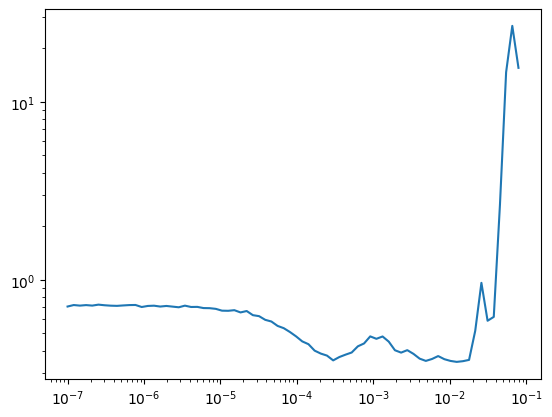

In [6]:
def lr_finder(
	train_dataset: list[tuple[torch.Tensor, torch.Tensor]],
	batch_size: int,
	dropout: float,
	weight_decay: float,
	smoothing: float = 0.1,
	start_lr: float = 1e-7,
	end_lr: float = 10,
	num_it: int = 100,
	beta: float = 0.98,
):
	learning_rates = np.geomspace(start_lr, end_lr, num_it)
	model = NsfwClassifier(768, dropout=dropout, outputs=2).to('cpu')

	train_dataloader = DataLoader(
		dataset=TensorDataset(torch.stack([x for x, y in train_dataset]), torch.stack([y for x, y in train_dataset])),
		batch_size=batch_size,
		shuffle=True,
	)

	loss_function = nn.CrossEntropyLoss()
	optimizer = optim.AdamW(model.parameters(), lr=1.0, weight_decay=weight_decay)

	dataset_iter = iter(train_dataloader)
	training_losses = []
	training_lrs = []
	smooth_loss = None
	avg_loss = None
	best_loss = 1000000000

	for lr in learning_rates:
		# Set learning rate
		for param_group in optimizer.param_groups:
			param_group['lr'] = lr

		# Get batch
		try:
			x, y = next(dataset_iter)
		except StopIteration:
			random.shuffle(train_dataset)
			dataset_iter = iter(train_dataloader)
			x, y = next(dataset_iter)
		
		# Label smoothing
		with torch.no_grad():
			bsz = y.size(0)
			smoothed_labels = torch.full(size=(bsz, 2), fill_value=smoothing / (2 - 1))
			smoothed_labels.scatter_(1, y.unsqueeze(1), 1.0 - smoothing)
			y = smoothed_labels
		
		# Train
		model.train()
		output = model(x)
		loss = loss_function(output, y)
		optimizer.zero_grad(set_to_none=True)
		loss.backward()
		optimizer.step()

		training_losses.append(loss.item())
		training_lrs.append(lr)

		if avg_loss is None:
			avg_loss = loss
		else:
			avg_loss = beta * avg_loss + (1 - beta) * loss
		
		smooth_loss = avg_loss / (1 - beta ** (len(training_losses) + 1))
		
		best_loss = min(best_loss, smooth_loss)

		if smooth_loss > 4 * best_loss or torch.isnan(smooth_loss):
			break
	
	return {
		"training_losses": training_losses,
		"training_lrs": training_lrs,
	}


results = lr_finder(
	train_dataset=train_dataset,
	batch_size=256,
	dropout=0.1,
	weight_decay=0.1,
)

plt.plot(results['training_lrs'][:-2], results['training_losses'][:-2])
plt.xscale('log')
plt.yscale('log')
plt.show()

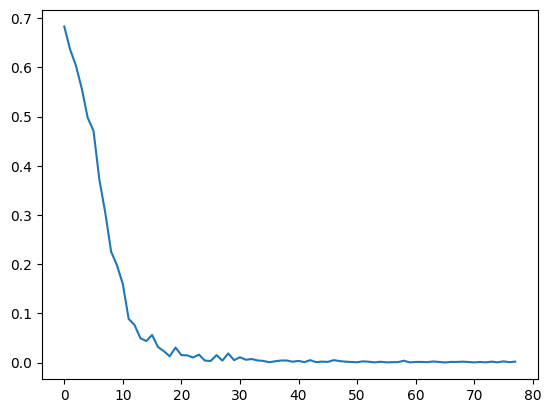

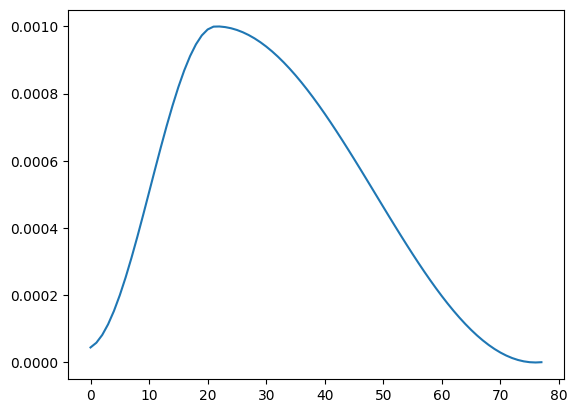

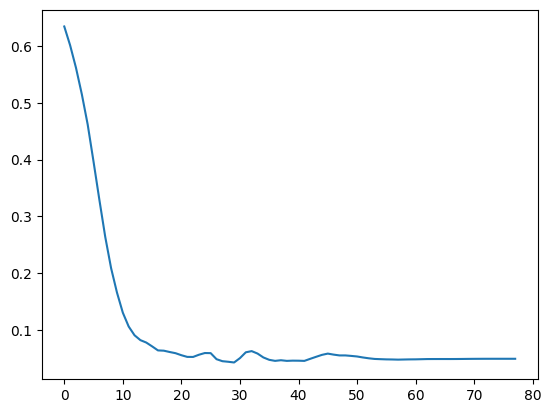

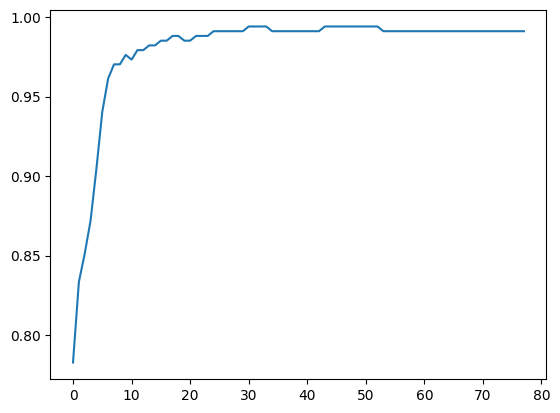

Test loss: 0.04879970848560333
Test accuracy: 0.9910714285714286


In [6]:
@torch.no_grad()
def test(model, dataloader: DataLoader, loss_function) -> float:
	model.eval()

	corrects = []
	loss_sum = torch.zeros(1, dtype=torch.float32, device='cpu', requires_grad=False)

	for x, y in dataloader:
		output = model(x)
		loss = loss_function(output, y)
		loss_sum.add_(loss)
		probs = F.softmax(output, dim=1)
		predictions = torch.argmax(probs, dim=1)
		correct = (predictions == y).tolist()
		corrects.extend(correct)
	
	mean_loss = loss_sum / len(dataloader)
	return sum(corrects) / len(corrects), mean_loss.item()


def train_a_model(
	train_dataset: list[tuple[torch.Tensor, torch.Tensor]],
	test_dataset: list[tuple[torch.Tensor, torch.Tensor]],
	batch_size: int,
	learning_rate: float,
	dropout: float,
	training_samples: int,
	test_every: int,
	weight_decay: float,
	smoothing: float = 0.1,
):
	model = NsfwClassifier(768, dropout=dropout, outputs=2).to('cpu')

	training_steps = max(1, training_samples // batch_size)
	test_every_steps = max(1, test_every // batch_size)

	train_dataloader = DataLoader(
		dataset=TensorDataset(torch.stack([x for x, y in train_dataset]), torch.stack([y for x, y in train_dataset])),
		batch_size=batch_size,
		shuffle=True,
	)

	test_dataloader = DataLoader(
		dataset=TensorDataset(torch.stack([x for x, y in test_dataset]), torch.stack([y for x, y in test_dataset])),
		batch_size=batch_size,
		shuffle=False,
	)

	loss_function = nn.CrossEntropyLoss()
	optimizer = optim.AdamW(model.parameters(), lr=1.0, weight_decay=weight_decay)
	lr_scheduler = OneCycleLR(
		optimizer=optimizer,
		max_lr=learning_rate,
		total_steps=training_steps,
	)

	dataset_iter = iter(train_dataloader)
	training_losses = []
	training_lrs = []
	test_losses = []
	test_accuracies = []

	for step in range(training_steps):
		# Get batch
		try:
			x, y = next(dataset_iter)
		except StopIteration:
			random.shuffle(train_dataset)
			dataset_iter = iter(train_dataloader)
			x, y = next(dataset_iter)
		
		# Label smoothing
		with torch.no_grad():
			bsz = y.size(0)
			smoothed_labels = torch.full(size=(bsz, 2), fill_value=smoothing / (2 - 1))
			smoothed_labels.scatter_(1, y.unsqueeze(1), 1.0 - smoothing)
			y = smoothed_labels
		
		# Train
		model.train()
		output = model(x)
		loss = loss_function(output, y)
		optimizer.zero_grad(set_to_none=True)
		loss.backward()
		optimizer.step()
		lr_scheduler.step()

		# Test
		if step % test_every_steps == 0:
			test_acc, test_loss = test(model, test_dataloader, loss_function)
			test_losses.append(test_loss)
			test_accuracies.append(test_acc)
		
		training_losses.append(loss.item())
		training_lrs.append(lr_scheduler.get_last_lr()[0])
	
	return {
		"training_losses": training_losses,
		"training_lrs": training_lrs,
		"test_losses": test_losses,
		"test_accuracies": test_accuracies,
		"model": model,
	}



batch_size = 256
training_samples = 20000

learning_rate = 1e-3
dropout = 0.1
weight_decay = 0.1

result = train_a_model(
	train_dataset=train_dataset,
	test_dataset=test_dataset,
	batch_size=batch_size,
	learning_rate=learning_rate,
	dropout=dropout,
	training_samples=training_samples,
	test_every=64,
	weight_decay=weight_decay,
	smoothing=0.0,
)
min_test_loss = result["test_losses"][-1]


plt.plot(result['training_losses'])
plt.show()

plt.plot(result['training_lrs'])
plt.show()

plt.plot(result['test_losses'])
plt.show()

plt.plot(result['test_accuracies'])
plt.show()


print(f"Test loss: {min_test_loss}")
print(f"Test accuracy: {result['test_accuracies'][-1]}")

best_model = result

In [7]:
torch.save(best_model['model'].state_dict(), "classifier.pt")

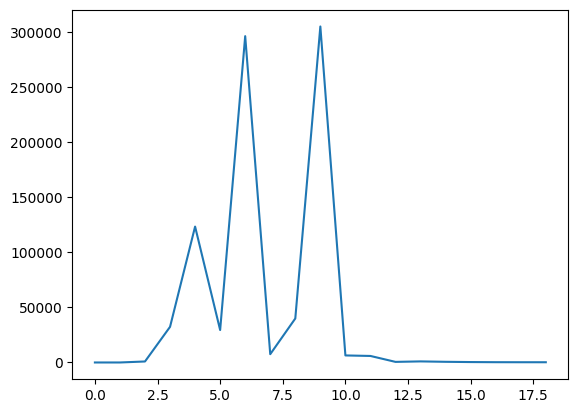

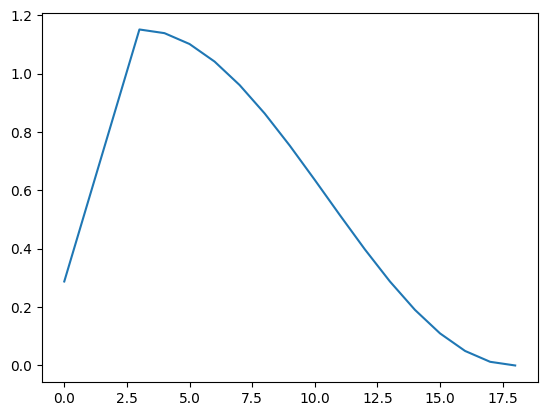

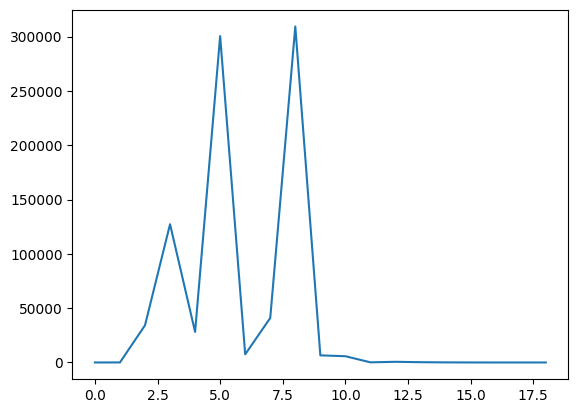

In [11]:
import matplotlib.pyplot as plt
plt.plot(best_model['training_losses'])
plt.show()

plt.plot(best_model['training_lrs'])
plt.show()

plt.plot(best_model['test_losses'])
plt.show()

In [ ]:
@torch.no_grad()
def test(model, dataloader: DataLoader, loss_function) -> float:
	model.eval()

	corrects = []
	loss_sum = torch.zeros(1, dtype=torch.float32, device='cpu', requires_grad=False)

	for x, y in dataloader:
		output = model(x)
		loss = loss_function(output, y)
		loss_sum.add_(loss)
		probs = F.softmax(output, dim=1)
		predictions = torch.argmax(probs, dim=1)
		correct = (predictions == y).tolist()
		corrects.extend(correct)
	
	mean_loss = loss_sum / len(dataloader)
	return sum(corrects) / len(corrects), mean_loss.item()


def train_a_model(
	train_dataset: list[tuple[torch.Tensor, torch.Tensor]],
	test_dataset: list[tuple[torch.Tensor, torch.Tensor]],
	batch_size: int,
	learning_rate: float,
	dropout: float,
	warmup_samples: int,
	training_samples: int,
	test_every: int,
	weight_decay: float,
	smoothing: float = 0.1,
):
	model = NsfwClassifier(768, dropout=dropout, outputs=2).to('cpu')

	warmup_steps = warmup_samples // batch_size
	training_steps = max(1, training_samples // batch_size)
	test_every_steps = max(1, test_every // batch_size)

	train_dataloader = DataLoader(
		dataset=TensorDataset(torch.stack([x for x, y in train_dataset]), torch.stack([y for x, y in train_dataset])),
		batch_size=batch_size,
		shuffle=True,
	)

	test_dataloader = DataLoader(
		dataset=TensorDataset(torch.stack([x for x, y in test_dataset]), torch.stack([y for x, y in test_dataset])),
		batch_size=batch_size,
		shuffle=False,
	)

	loss_function = nn.CrossEntropyLoss()
	#optimizer = optim.SGD(model.parameters(), lr=learning_rate)
	optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
	lr_scheduler = get_scheduler(
		name="cosine",
		optimizer=optimizer,
		num_warmup_steps=warmup_steps,
		num_training_steps=training_steps,
	)

	#test_before, test_loss_before = test(model, test_dataloader, loss_function)
	#print(f"Test accuracy before training: {test_before}")
	#print(f"Test loss before training: {test_loss_before}")

	dataset_iter = iter(train_dataloader)
	training_losses = []
	training_lrs = []
	test_losses = []
	test_accuracies = []

	for step in range(training_steps):
		# Get batch
		try:
			x, y = next(dataset_iter)
		except StopIteration:
			random.shuffle(train_dataset)
			dataset_iter = iter(train_dataloader)
			x, y = next(dataset_iter)
		
		# Label smoothing
		with torch.no_grad():
			bsz = y.size(0)
			smoothed_labels = torch.full(size=(bsz, 2), fill_value=smoothing / (2 - 1))
			smoothed_labels.scatter_(1, y.unsqueeze(1), 1.0 - smoothing)
			y = smoothed_labels
		
		# Train
		model.train()
		output = model(x)
		loss = loss_function(output, y)
		optimizer.zero_grad(set_to_none=True)
		loss.backward()
		optimizer.step()
		lr_scheduler.step()

		# Test
		if step % test_every_steps == 0:
			test_acc, test_loss = test(model, test_dataloader, loss_function)
			test_losses.append(test_loss)
			test_accuracies.append(test_acc)
		
		training_losses.append(loss.item())
		training_lrs.append(lr_scheduler.get_last_lr()[0])
	
	return {
		"training_losses": training_losses,
		"training_lrs": training_lrs,
		"test_losses": test_losses,
		"test_accuracies": test_accuracies,
		"model": model,
	}


# Random hyperparameter search
batch_size = 512
training_samples = 10000

# Ranges
learning_rates = (0.000001, 1.5)
dropouts = (0.0, 0.5)
warmup_pcts = (0.0, 0.5)
weight_decays = (0.0, 0.3)

best_model = None
best_model_test_loss = 1000000

for i in range(256):
	learning_rate = 10 ** random.uniform(*np.log10(learning_rates))
	dropout = random.uniform(*dropouts)
	warmup_pct = random.uniform(*warmup_pcts)
	weight_decay = random.uniform(*weight_decays)

	result = train_a_model(
		train_dataset=train_dataset,
		test_dataset=test_dataset,
		batch_size=batch_size,
		learning_rate=learning_rate,
		dropout=dropout,
		warmup_samples=int(warmup_pct * training_samples),
		training_samples=training_samples,
		test_every=64,
		weight_decay=weight_decay,
	)
	#min_test_loss = min(result["test_losses"])
	min_test_loss = result["test_losses"][-1]

	if min_test_loss < best_model_test_loss:
		best_model = result
		best_model_test_loss = min_test_loss
		best_model['learning_rate'] = learning_rate
		best_model['dropout'] = dropout
		best_model['warmup_pct'] = warmup_pct
		best_model['weight_decay'] = weight_decay
		best_model['test_acc'] = max(result["test_accuracies"])

assert best_model is not None
print(f"Best model test loss: {best_model_test_loss}")
print(f"Best model test accuracy: {best_model['test_acc']}")
print(f"Best model learning rate: {best_model['learning_rate']}")
print(f"Best model dropout: {best_model['dropout']}")
print(f"Best model warmup pct: {best_model['warmup_pct']}")
print(f"Best model weight decay: {best_model['weight_decay']}")